# Get The Data

In [1]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
raw_data = pd.read_csv('data/liked_labeled.csv')

In [3]:
labeled_songs = raw_data.copy()
labeled_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4296 entries, 0 to 4295
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4296 non-null   int64  
 1   Track URI             4296 non-null   object 
 2   Track Name            4296 non-null   object 
 3   Artist URI(s)         4296 non-null   object 
 4   Artist Name(s)        4296 non-null   object 
 5   Album URI             4296 non-null   object 
 6   Album Name            4296 non-null   object 
 7   Album Artist URI(s)   4296 non-null   object 
 8   Album Artist Name(s)  4296 non-null   object 
 9   Album Release Date    4296 non-null   object 
 10  Album Image URL       4296 non-null   object 
 11  Disc Number           4296 non-null   int64  
 12  Track Number          4296 non-null   int64  
 13  Track Duration (ms)   4296 non-null   int64  
 14  Track Preview URL     3247 non-null   object 
 15  Explicit             

In [4]:
labeled_songs.describe()

,Unnamed: 0,Disc Number,Track Number,Track Duration (ms),Popularity,Added By,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
count,4296.000000,4296.000000,4296.000000,4.296000e+03,4296.000000,0.0,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000
mean,2147.500000,1.032588,6.540503,2.423103e+05,31.929004,NaN,0.563541,0.533308,5.220825,-10.394896,0.612625,0.103522,0.374874,0.323438,0.192953,0.387757,117.886939,3.894712
std,1240.292707,0.321318,6.242312,2.894246e+05,23.515855,NaN,0.185046,0.247769,3.635817,6.086908,0.487207,0.122246,0.344682,0.383817,0.163539,0.249579,30.341885,0.472055
min,0.000000,1.000000,1.000000,4.800000e+03,0.000000,NaN,0.000000,0.000098,0.000000,-46.829000,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1073.750000,1.000000,2.000000,1.648762e+05,7.000000,NaN,0.453000,0.360000,2.000000,-12.582000,0.000000,0.037200,0.047200,0.000082,0.098500,0.175000,93.919000,4.000000
50%,2147.500000,1.000000,5.000000,2.148260e+05,34.000000,NaN,0.584000,0.550000,5.000000,-8.774000,1.000000,0.050900,0.274000,0.047200,0.121000,0.363000,117.964000,4.000000
75%,3221.250000,1.000000,9.000000,2.657785e+05,51.000000,NaN,0.694000,0.729000,8.000000,-6.421000,1.000000,0.105000,0.703000,0.781000,0.229000,0.573000,137.941000,4.000000
max,4295.000000,11.000000,42.000000,9.146416e+06,96.000000,NaN,0.980000,0.993000,11.000000,-0.394000,1.000000,0.928000,0.996000,0.991000,0.985000,0.982000,214.131000,5.000000


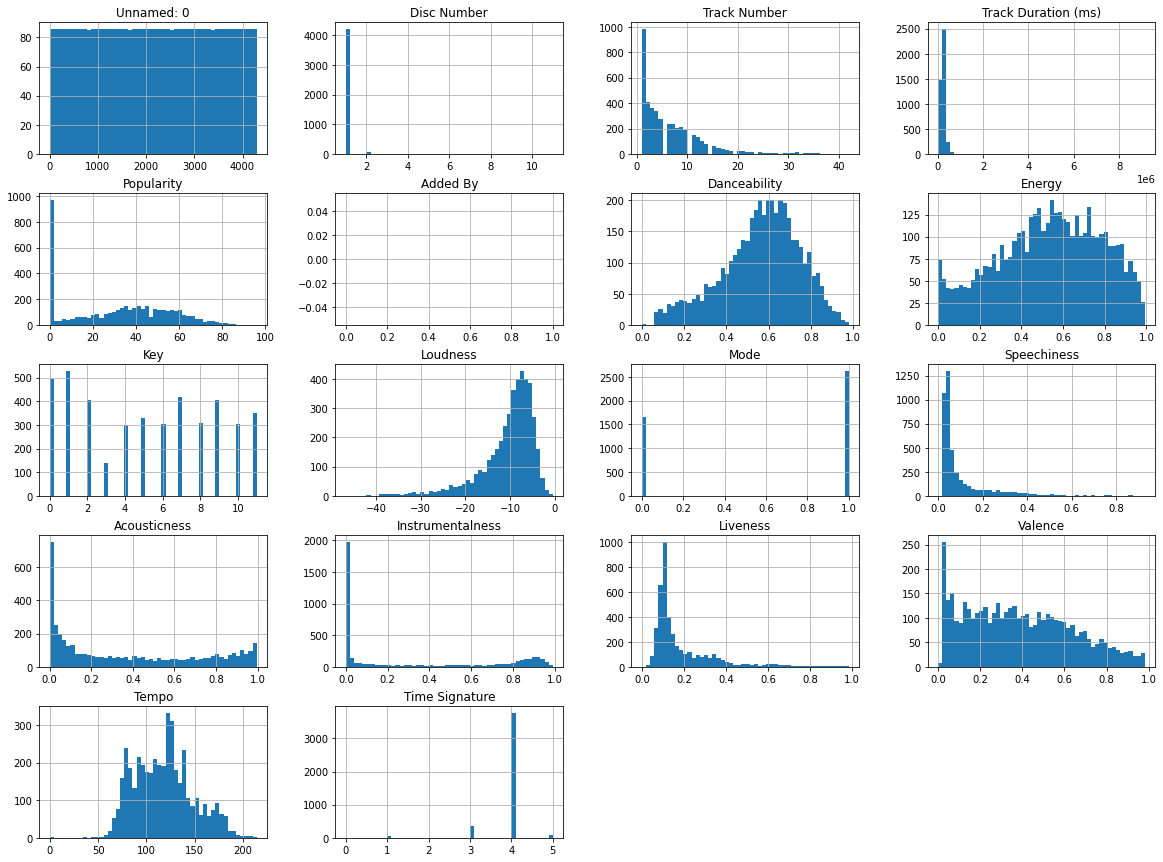

In [5]:
import matplotlib.pyplot as plt

labeled_songs.hist(bins = 50, figsize = (20,15))
plt.show()

# Removing Irrelevant Features From Dataset

In [6]:
features = ['Explicit', 
            'Popularity', 
            'Danceability', 
            'Energy', 
            'Key', 
            'Loudness', 
            'Mode', 
            'Speechiness', 
            'Acousticness', 
            'Instrumentalness', 
            'Liveness', 
            'Valence', 
            'Tempo', 
            'Time Signature',
            'Label']
labels = ['Label']

In [7]:
labeled_songs = labeled_songs[features]

In [8]:
labeled_songs['Key'] = labeled_songs['Key'].astype("category")
labeled_songs['Explicit'] = labeled_songs['Explicit'].astype("category")
labeled_songs['Mode'] = labeled_songs['Mode'].astype("category")

In [9]:
labeled_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4296 entries, 0 to 4295
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Explicit          4296 non-null   category
 1   Popularity        4296 non-null   int64   
 2   Danceability      4293 non-null   float64 
 3   Energy            4293 non-null   float64 
 4   Key               4293 non-null   category
 5   Loudness          4293 non-null   float64 
 6   Mode              4293 non-null   category
 7   Speechiness       4293 non-null   float64 
 8   Acousticness      4293 non-null   float64 
 9   Instrumentalness  4293 non-null   float64 
 10  Liveness          4293 non-null   float64 
 11  Valence           4293 non-null   float64 
 12  Tempo             4293 non-null   float64 
 13  Time Signature    4293 non-null   float64 
 14  Label             4296 non-null   bool    
dtypes: bool(1), category(3), float64(10), int64(1)
memory usage: 386.7 KB


In [10]:
labeled_songs['Explicit'].value_counts()

False    3567
True      729
Name: Explicit, dtype: int64

In [11]:
labeled_songs['Key'].value_counts()

1.0     530
0.0     495
7.0     417
9.0     407
2.0     405
11.0    352
5.0     329
8.0     309
10.0    306
6.0     305
4.0     298
3.0     140
Name: Key, dtype: int64

In [12]:
labeled_songs['Mode'].value_counts()

1.0    2630
0.0    1663
Name: Mode, dtype: int64

In [13]:
# Checking for imbalance in the dataset
labeled_songs['Label'].value_counts(True)

False    0.513035
True     0.486965
Name: Label, dtype: float64

In [14]:
for col in labeled_songs.columns:
    print(col, ":", labeled_songs[col].isnull().sum())

Explicit : 0
Popularity : 0
Danceability : 3
Energy : 3
Key : 3
Loudness : 3
Mode : 3
Speechiness : 3
Acousticness : 3
Instrumentalness : 3
Liveness : 3
Valence : 3
Tempo : 3
Time Signature : 3
Label : 0


In [15]:
labeled_songs[labeled_songs['Danceability'].isna()]

,Explicit,Popularity,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Label
491,False,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
703,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2067,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [16]:
# Drop rows that contain any null values
labeled_songs.dropna(inplace = True)

In [17]:
# Ensuring all features were fixed
for col in labeled_songs.columns:
    print(col, ":", labeled_songs[col].isnull().sum())

Explicit : 0
Popularity : 0
Danceability : 0
Energy : 0
Key : 0
Loudness : 0
Mode : 0
Speechiness : 0
Acousticness : 0
Instrumentalness : 0
Liveness : 0
Valence : 0
Tempo : 0
Time Signature : 0
Label : 0


In [18]:
# Replacing any NaN values with median
for col in labeled_songs.columns:
    if labeled_songs[col].isnull().sum() > 0 == True and labeled_songs[col].dtypes not in ['bool', 'category'] == True:
        labeled_songs[col] = labeled_songs[col].fillna(labeled_songs[col].median())

# Searching for Deeper Patterns

In [19]:
cmatrix = labeled_songs.corr()
cmatrix["Label"].sort_values(ascending = False)

Label               1.000000
Popularity          0.188560
Loudness            0.024206
Tempo               0.024164
Danceability        0.024129
Time Signature      0.023851
Energy              0.014470
Acousticness       -0.008568
Valence            -0.013575
Liveness           -0.044454
Instrumentalness   -0.076210
Speechiness        -0.095719
Name: Label, dtype: float64

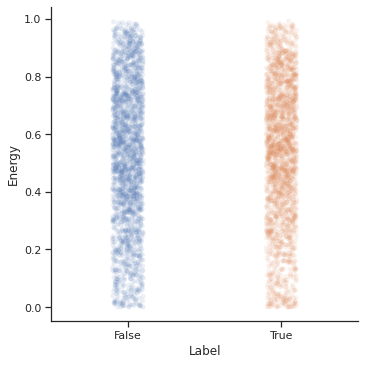

In [20]:
import seaborn as sns
sns.set_theme(style = "ticks", color_codes = True)
sns.catplot(x = "Label", y = "Energy", data = labeled_songs, alpha = 0.1)

In [21]:
features[:-1]

['Explicit',
 'Popularity',
 'Danceability',
 'Energy',
 'Key',
 'Loudness',
 'Mode',
 'Speechiness',
 'Acousticness',
 'Instrumentalness',
 'Liveness',
 'Valence',
 'Tempo',
 'Time Signature']

I was not able to locate any apparent patterns that met the eye during this phase, however, I do believe that some patterns would emerge if i were to generalize the data a bit more than it already is. Given this realization I have decided against generalizing the data even more by categorization in order for the model to learn very more granularly. This revelation has me considering a deep neural network rather than a simple classification model. I will try the simple approach first.

Can I combine the given features of a single observation into a 'fingerprint' of sorts and train a neural network to learn the intracacies of the image?

# Conventional Classification Approach

In [22]:
from sklearn.model_selection import train_test_split

ds_features = labeled_songs[features[:-1]]
ds_labels = labeled_songs['Label']

train_X, validation_X, train_Y, validation_Y  = train_test_split(ds_features,ds_labels,test_size = 0.20, random_state = 42)

In [23]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(max_depth = 5)
dt_model.fit(train_X, train_Y)

dt_model.score(validation_X, validation_Y)*100

59.25494761350407

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(max_depth = 5, n_estimators = 100)
rf_model.fit(train_X, train_Y)

rf_model.score(validation_X, validation_Y) * 100

61.69965075669383

# Neural Network Approach
In order to this we must tranform the labels into their 0 and 1 counterparts to fit the Binary classification specifications.

In [32]:
nn_train_X = train_X.copy()
nn_validation_X = validation_X.copy()

nn_train_Y = train_Y.copy()
nn_train_Y[nn_train_Y[:] == True] = 1.0

nn_validation_Y = validation_Y.copy()
nn_validation_Y[nn_validation_Y[:] == True] = 1.0

In [71]:
# integer encoding for categorical variables
for col in nn_train_X.columns:
    if nn_train_X[col].dtypes.name == 'category':
        nn_train_X[col] = nn_train_X[cols].astype("float64")

for col in nn_validation_X.columns:
    if nn_validation_X[col].dtypes.name == 'category':
        nn_validation_X[col] = nn_validation_X[cols].astype("float64")

In [72]:
nn_validation_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 859 entries, 3533 to 1730
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Explicit          859 non-null    float64
 1   Popularity        859 non-null    int64  
 2   Danceability      859 non-null    float64
 3   Energy            859 non-null    float64
 4   Key               859 non-null    float64
 5   Loudness          859 non-null    float64
 6   Mode              859 non-null    float64
 7   Speechiness       859 non-null    float64
 8   Acousticness      859 non-null    float64
 9   Instrumentalness  859 non-null    float64
 10  Liveness          859 non-null    float64
 11  Valence           859 non-null    float64
 12  Tempo             859 non-null    float64
 13  Time Signature    859 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 133.0 KB


In [73]:
nn_validation_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 859 entries, 3533 to 1730
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Explicit          859 non-null    float64
 1   Popularity        859 non-null    int64  
 2   Danceability      859 non-null    float64
 3   Energy            859 non-null    float64
 4   Key               859 non-null    float64
 5   Loudness          859 non-null    float64
 6   Mode              859 non-null    float64
 7   Speechiness       859 non-null    float64
 8   Acousticness      859 non-null    float64
 9   Instrumentalness  859 non-null    float64
 10  Liveness          859 non-null    float64
 11  Valence           859 non-null    float64
 12  Tempo             859 non-null    float64
 13  Time Signature    859 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 133.0 KB


In [74]:
# Normalizing data
nn_train_X -= nn_train_X.mean(axis = 0)
nn_train_X /= nn_train_X.std(axis = 0)

In [75]:
nn_validation_X -= nn_validation_X.mean(axis = 0)
nn_validation_X /= nn_validation_X.std(axis = 0)

In [81]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

nn_model = Sequential()
nn_model.add(Dense(8, input_dim = len(ds_features.columns), activation = 'relu'))
nn_model.add(Dense(4, activation = 'relu'))
nn_model.add(Dense(2, activation = 'relu'))
nn_model.add(Dense(1, activation = 'sigmoid'))

nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8)                 120       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 3         
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [82]:
# Compiling the neural network
nn_model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

In [83]:
# Training model
nn_model.fit(nn_train_X, nn_train_Y, epochs = 1000, verbose = True)

===] - 0s 1ms/step - loss: 0.6215 - accuracy: 0.6322
Epoch 810/1000
108/108 [==============================] - 0s 1ms/step - loss: 0.6217 - accuracy: 0.6366
Epoch 811/1000
108/108 [==============================] - 0s 1ms/step - loss: 0.6214 - accuracy: 0.6345
Epoch 812/1000
108/108 [==============================] - 0s 986us/step - loss: 0.6217 - accuracy: 0.6351
Epoch 813/1000
108/108 [==============================] - 0s 1ms/step - loss: 0.6207 - accuracy: 0.6319
Epoch 814/1000
108/108 [==============================] - 0s 923us/step - loss: 0.6211 - accuracy: 0.6325
Epoch 815/1000
108/108 [==============================] - 0s 934us/step - loss: 0.6215 - accuracy: 0.6348
Epoch 816/1000
108/108 [==============================] - 0s 990us/step - loss: 0.6211 - accuracy: 0.6366
Epoch 817/1000
108/108 [==============================] - 0s 1ms/step - loss: 0.6218 - accuracy: 0.6342
Epoch 818/1000
108/108 [==============================] - 0s 1ms/step - loss: 0.6216 - accuracy: 0.6345
Epo

In [93]:
# Evaluating the neural network
nn_predictions = nn_model.predict(nn_validation_X).round()

In [95]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc_score = accuracy_score(nn_validation_Y, nn_predictions)
acc_score

0.5972060535506403

In [96]:
prec_score = precision_score(nn_validation_Y, nn_predictions)
prec_score

0.544891640866873

In [97]:
rec_score = recall_score(nn_validation_Y, nn_predictions)
rec_score

0.4693333333333333

In [98]:
f1 = f1_score(nn_validation_Y, nn_predictions)
f1

0.5042979942693411